In [1]:
pip install tensorflow opencv-python pandas scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


In [3]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [4]:
# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 30
CLASSES_LIST = ["E05(Circumduction)"]


In [5]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [6]:
def create_dataset(video_dir, csv_file_path):
    features = []
    labels = []
    video_files_paths = []
    matching_files_count = 0

    # Read the CSV file
    csv_data = pd.read_csv(csv_file_path)

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(video_dir, class_name))

        for file_name in files_list:
            # Remove the .mp4 extension from the file name
            video_name = os.path.splitext(file_name)[0]

            video_file_path = os.path.join(video_dir, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                # Search for the exercise name in the CSV data that matches with video file name
                matching_row = csv_data[csv_data['Excercise Name'].str.lower() == video_name.lower()]

                if not matching_row.empty:
                    assessment_score = matching_row['Assessment Score'].values[0]
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
                    matching_files_count += 1
                    print(f'Matched file: {video_name}, Assessment Score: {assessment_score}')
                else:
                    # Append None if no matching row is found
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
                    print(f'No matching row found for file: {video_name}')

    features = np.asarray(features)
    labels = np.asarray(labels)

    print(f'Total matching files: {matching_files_count}')

    return features, labels, matching_files_count, video_files_paths


In [7]:
import pandas as pd

video_dir = '/kaggle/input/regression-folders/dataset_regression'
csv_file_path = '/kaggle/input/csv-files-regression/Ex_05_sub.csv'
features, labels, matching_files_count, video_files_paths =  create_dataset(video_dir, csv_file_path)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Matching files count:", matching_files_count)
print("Number of video files:", len(video_files_paths))

Extracting Data of Class: E05(Circumduction)
Matched file: E05_P36_AL_VFL_GM, Assessment Score: 53.81
Matched file: E05_P32_AR_VFL_GM, Assessment Score: 19.05
Matched file: E05_P29_AL_VFL_GM, Assessment Score: 33.33
Matched file: E05_P31_AF_VML_GM, Assessment Score: 67.14
Matched file: E05_P21_AF_VLL_GM, Assessment Score: 62.38
Matched file: E05_P02_AF_VHJ_GM, Assessment Score: 70.48
Matched file: E05_P12_AL_VML_GF, Assessment Score: 82.86
Matched file: E05_P13_AR_VML_GF, Assessment Score: 78.1
Matched file: E05_P01_AR_VFL_GM, Assessment Score: 75.71
Matched file: E05_P31_AF_VLR_GM, Assessment Score: 67.14
Matched file: E05_P01_AF_VHJ_GM, Assessment Score: 84.29
Matched file: E05_P22_AF_VHJ_GM, Assessment Score: 76.67
Matched file: E05_P07_AR_VHJ_GM, Assessment Score: 60.0
Matched file: E05_P34_AF_VHJ_GF, Assessment Score: 16.67
Matched file: E05_P36_AF_VML_GM, Assessment Score: 50.0
Matched file: E05_P01_AF_VFL_GM, Assessment Score: 78.57
Matched file: E05_P22_AR_VLJ_GM, Assessment Sc

In [8]:
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

In [9]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.20, shuffle=True, random_state=42
)

print(f"Training features: {features_train.shape}, Training labels: {labels_train.shape}")
print(f"Testing features: {features_test.shape}, Testing labels: {labels_test.shape}")


Training features: (64, 30, 128, 128, 3), Training labels: (64,)
Testing features: (16, 30, 128, 128, 3), Testing labels: (16,)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define RMSE and MAD as custom metrics with correct casting
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mad(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    return tf.reduce_mean(tf.abs(y_pred - tf.reduce_mean(y_pred)))

# Define the LSTM model
def create_lstm_model(SEQUENCE_LENGTH, FEATURE_SIZE):
    """
    An LSTM model for sequence prediction.
    Args:
    - SEQUENCE_LENGTH: Length of the input sequence.
    - FEATURE_SIZE: Number of features in each time step.
    """
    # Define the sequence input (3D input for LSTM)
    sequence_input = layers.Input(shape=(SEQUENCE_LENGTH, FEATURE_SIZE))
    
    # First LSTM layer with return_sequences=True for stacked LSTM
    x = layers.LSTM(
        units=64,
        activation='relu',
        return_sequences=True
    )(sequence_input)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    # Second LSTM layer with return_sequences=False for final output
    x = layers.LSTM(
        units=128,
        activation='relu',
        return_sequences=False
    )(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # Dense layer with sigmoid activation to scale output to [0, 1]
    regression_output = layers.Dense(1, activation='sigmoid', name='regression_output')(x)
    
    # Build the model
    model = models.Model(inputs=sequence_input, outputs=[regression_output])
    model.summary()
    
    return model

# Determine FEATURE_SIZE for RGB input
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNELS = 3  # RGB
FEATURE_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH * CHANNELS  # Flattened spatial and channel dimensions

# Reshape features
features_train = features_train.reshape(features_train.shape[0], features_train.shape[1], FEATURE_SIZE)
features_test = features_test.reshape(features_test.shape[0], features_test.shape[1], FEATURE_SIZE)

print(f"Reshaped features_train: {features_train.shape}")
print(f"Reshaped features_test: {features_test.shape}")

# Recreate model with updated FEATURE_SIZE
model = create_lstm_model(SEQUENCE_LENGTH, FEATURE_SIZE)



Reshaped features_train: (64, 30, 49152)
Reshaped features_test: (16, 30, 49152)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 49152)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │    12,599,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output (Dense)       │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,699,265 (48.44 MB)

 Trainable params: 12,698,881 (48.44 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',  # Use MSE for regression
              metrics=['mean_absolute_error', rmse, mad])

# Define Early Stopping and Learning Rate Scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.5 if epoch % 5 == 0 and epoch > 0 else lr, verbose=1)

callbacks = [early_stopping, lr_scheduler]

# Train the model
history = model.fit(features_train, labels_train,
                    validation_data=(features_test, labels_test),
                    epochs=60, batch_size=8, verbose=1, 
                    callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - loss: 0.3093 - mad: 0.2080 - mean_absolute_error: 0.4950 - rmse: 0.5553 - val_loss: 0.4326 - val_mad: 0.3256 - val_mean_absolute_error: 0.5525 - val_rmse: 0.6572 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.2980 - mad: 0.1859 - mean_absolute_error: 0.4966 - rmse: 0.5452 - val_loss: 0.0146 - val_mad: 0.0550 - val_mean_absolute_error: 0.0852 - val_rmse: 0.1195 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.2893 - mad: 0.1730 - mean_absolute_error: 0.4937 - rmse: 0.5376 - val_loss: 0.1120 - val_mad: 0.0637 - val_mean_absolute_error: 0.3253 - val_rmse: 0.3338 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting 

In [13]:
# Evaluate the model on the test data
evaluation = model.evaluate(features_test, labels_test)

# Print the evaluation results with four decimal places
print(f"Evaluation Loss (MSE): {evaluation[0]:.5f}")
print(f"Evaluation MAE: {evaluation[1]:.5f}")
print(f"Evaluation RMSE: {evaluation[2]:.5f}")
print(f"Evaluation MAD: {evaluation[3]:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step - loss: 0.0146 - mad: 0.0600 - mean_absolute_error: 0.0852 - rmse: 0.1209
Evaluation Loss (MSE): 0.01461
Evaluation MAE: 0.08521
Evaluation RMSE: 0.12088
Evaluation MAD: 0.06001


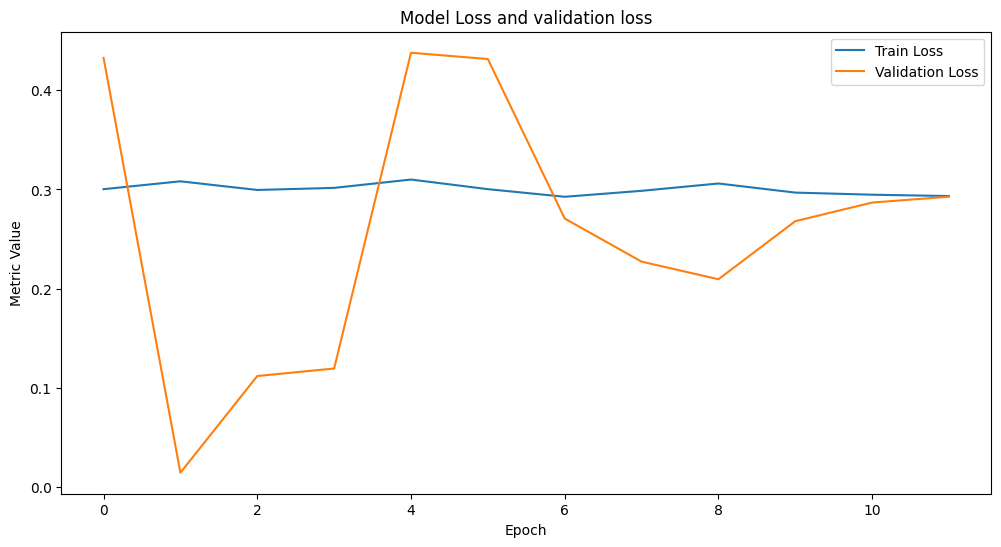

In [14]:
# Plot the Train loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

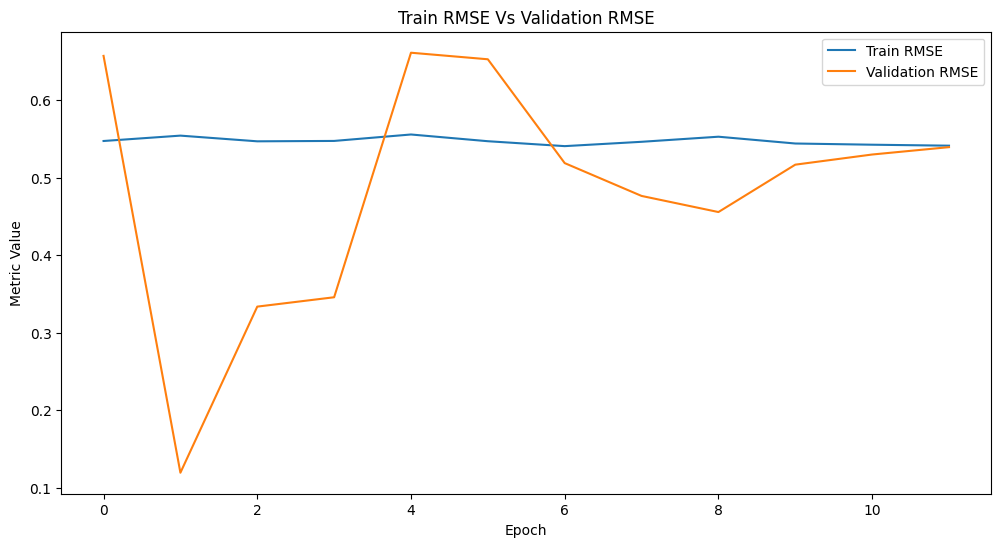

In [15]:
# Plot the train rmse and validation rmse
plt.figure(figsize=(12, 6))
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Train RMSE Vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


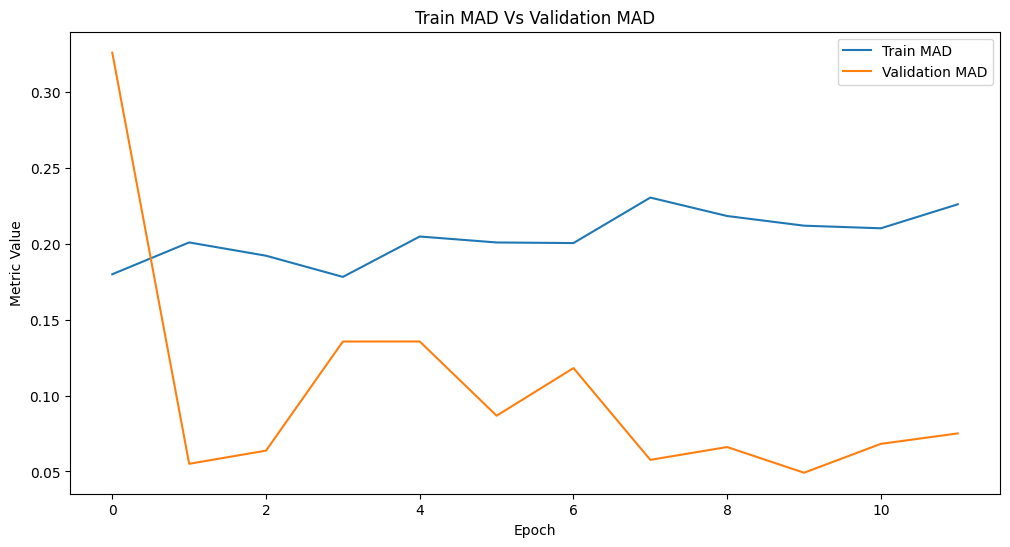

In [16]:
# Plot the tain MAD and validation MAD
plt.figure(figsize=(12, 6))
plt.plot(history.history['mad'], label='Train MAD')
plt.plot(history.history['val_mad'], label='Validation MAD')
plt.title('Train MAD Vs Validation MAD')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()



In [17]:
model.save('LSTM(E05).h5')

In [18]:
import os
import cv2
import numpy as np

# Function to save all split videos from the test set to a folder
def save_all_split_videos(video_data, save_dir, SEQUENCE_LENGTH=16, IMAGE_HEIGHT=64, IMAGE_WIDTH=64, fps=30):
    """
    Save all split videos from the video data as individual video files in the specified directory.

    Args:
        video_data: Numpy array containing video data of shape (num_videos, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3).
        save_dir: Directory to save the videos.
        SEQUENCE_LENGTH: Number of frames per video (default is 16).
        IMAGE_HEIGHT: Height of the frames (default is 64).
        IMAGE_WIDTH: Width of the frames (default is 64).
        fps: Frames per second for the output videos (default is 30).
    """
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Iterate over all videos in the dataset
    for video_index in range(video_data.shape[0]):
        video_frames = video_data[video_index]  # Shape: (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

        # Prepare the VideoWriter object to save the video
        video_filename = os.path.join(save_dir, f"split_video_{video_index + 1}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for .mp4 format
        video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Add frames to the video
        for frame in video_frames:
            # Ensure the frame has values in the range [0, 255] and convert to uint8
            frame_rgb = (frame * 255).astype(np.uint8)
            # Convert RGB to BGR for OpenCV
            frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
            # Write the frame to the video
            video_writer.write(frame_bgr)

        # Release the video writer
        video_writer.release()
        print(f"Video {video_index + 1} saved to: {video_filename}")

# Example usage: Save all split videos from the test set
# Make sure `features_test` is defined before calling this function
save_all_split_videos(features_test, save_dir="/kaggle/working/split_videos")


Video 1 saved to: /kaggle/working/split_videos/split_video_1.mp4
Video 2 saved to: /kaggle/working/split_videos/split_video_2.mp4
Video 3 saved to: /kaggle/working/split_videos/split_video_3.mp4
Video 4 saved to: /kaggle/working/split_videos/split_video_4.mp4
Video 5 saved to: /kaggle/working/split_videos/split_video_5.mp4
Video 6 saved to: /kaggle/working/split_videos/split_video_6.mp4
Video 7 saved to: /kaggle/working/split_videos/split_video_7.mp4
Video 8 saved to: /kaggle/working/split_videos/split_video_8.mp4
Video 9 saved to: /kaggle/working/split_videos/split_video_9.mp4
Video 10 saved to: /kaggle/working/split_videos/split_video_10.mp4
Video 11 saved to: /kaggle/working/split_videos/split_video_11.mp4
Video 12 saved to: /kaggle/working/split_videos/split_video_12.mp4
Video 13 saved to: /kaggle/working/split_videos/split_video_13.mp4
Video 14 saved to: /kaggle/working/split_videos/split_video_14.mp4
Video 15 saved to: /kaggle/working/split_videos/split_video_15.mp4
Video 16 save

In [21]:
# Example prediction for a new video
video_path = '/kaggle/input/test-regre/test_regre/E05_P60_AF_VHJ_GF.mp4'
def process_video(video_path):
    # Example preprocessing: Replace this with actual video processing logic
    video_data = np.random.random((SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Replace with real processing
    
    # Flatten spatial dimensions into FEATURE_SIZE
    FEATURE_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH * 3  # RGB channels
    video_data = video_data.reshape(SEQUENCE_LENGTH, FEATURE_SIZE)
    
    # Add batch dimension
    return np.expand_dims(video_data, axis=0)
predicted_score = model.predict(process_video(video_path))

scaled_score = predicted_score * 99 + 1
print(f"Predicted Score: {scaled_score[0][0]:.2f}")  # Assuming `predicted_score` is a 2D array



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Score: 6.14
